### Location Based Analysis of Mumbai's Bus Transport System

In the previous notebook, we looked at the network aspects of the transport system. Here, we will take a look at some basic location based aspects of the network and give some explanations regarding why certain locations (Bus stops) are more important than some other.  
The 'Open Street Maps' python library osmnx is the library used for this analysis. This library has many functionalities right from creating city administrative maps, to creating city road maps. Many places of significance can also be located with its point location on map with the help of this library.

#### Installing dependencies

In [ ]:
!pip install osmnx
!pip install geopandas
!pip install thefuzz

#### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We create the graph network in the same manner as the previous notebook using the routes.csv file.

In [5]:
routes = pd.read_csv('/content/drive/MyDrive/routes.csv')
routes['Stops'] = routes['Stops'].str.split(',')
def strip_spaces(lst):
  final = []
  for i in lst:
    final.append(i.lstrip(' '))
  return final

routes['Stops'] = routes['Stops'].apply(lambda x: strip_spaces(x))
for idx,row in routes.iterrows():
  previous_stop = None
  for i in row['Stops']:
    if previous_stop == i:
      row['Stops'].remove(i)
    previous_stop = i

G = nx.Graph()
paths = routes['Stops'].tolist()
for path in paths:
  for i in path:
    if i.upper() not in G.nodes():
      G.add_node(i.upper(),count=1)
    else:
      G.nodes[i.upper()]['count'] += 1
for path in paths:
  for i,j in zip(path[:-1],path[1:]):
    if (i.upper(),j.upper()) in G.edges() or (j.upper(),i.upper()) in G.edges():
      G[i.upper()][j.upper()]['count'] += 1
    else:
      G.add_edge(i.upper(),j.upper(),count=1)


Now we will try to locate these bus stops from out graph on map of Mumbai using osmnx. Note that all bus stops will not be found as many of the stops are not of high importance with respect to footfall and hence even though they are stops, they might not be locatable from osmnx. Some stops also are located outside Mumbai as discussed earlier which means these will also be ignored.  
Here we first create a set of all nodes from out graphs, ie. a list of all bus stops.  
In osmnx, we can use different tags to find our place of interest, whether it may be a bus stop like in this case, or any building, park, landmark, etc. Thus we use the 'bus_stop' tag to get all the bus stops in Mumbai. We convert the names to a set too.  


In [6]:
scraped_stops = set()
for idx,row in routes.iterrows():
    for i in row['Stops']:
        scraped_stops.add(i)

In [7]:
data = ox.geometries.geometries_from_place('Mumbai',tags={'highway':'bus_stop'})
osm_stops = set(data['name'].tolist())

We first try to find exact matches to bus stop names in the Open Street Maps version and the routes data. If a bus stop names from routes matches exactly with a bus stop name in osm data, we can be confident that those are the exact locations for those stops and hence map them directly.  
As for the remaining ones, there are around only .. exact matches. Hence for mapping the remaining bus stops we use fuzzy matching. Fuzzy matching is approximate string matching which helps to find similar strings to a given input. Here, we try to fuzzy match each stop from routes data. If we have a very high fuzzy score (match score), we can map those open street maps stops to the routes data stops. After careful examination and self validating the matches, we delete the ones which are wrongly matched and left with .. stops.  

In [9]:
from thefuzz import fuzz

all_geometries = []
all_scraped_names = []
all_osm_names = []
for i in scraped_stops:
  if i in osm_stops:
    all_scraped_names.append(i)
    all_osm_names.append(i)
    all_geometries.append(data[data['name']==i].iloc[0]['geometry'])

for i in scraped_stops.difference(set(all_scraped_names)):
  for j in osm_stops.difference(set(all_osm_names)):
    score = fuzz.token_set_ratio(i,j)
    if score >= 95:
      all_scraped_names.append(i)
      all_osm_names.append(j)
      all_geometries.append(data[data['name']==j].iloc[0]['geometry'])

locations = pd.DataFrame({'scraped_stop':all_scraped_names, 'osm_stop':all_osm_names,'geometry':all_geometries})
locations = gpd.GeoDataFrame(locations)
locations['scraped_stop'] = locations['scraped_stop'].str.upper()
locations['osm_stop'] = locations['osm_stop'].str.upper()

In [10]:
random_locations = locations.sample(10)
random_locations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

,scraped_stop,osm_stop,geometry
93,MATRUCHAYA,MATRUCHAYA,POINT (72.85194 19.10377)
44,NAVY NAGAR COLABA,NAVY NAGAR COLABA,POINT (72.80834 18.90746)
139,AUGUST KRANTI MAIDAN,AUGUST KRANTI MAIDAN,POINT (72.81055 18.96282)
301,SHANKAR MANDIR,SHANKAR MANDIR STOP,POINT (72.89745 19.02845)
185,CHEETA CAMP TROMBAY,CHEETA CAMP,POINT (72.94467 19.03848)
174,SIDDHARTH NAGAR,PODDAR HOSPITAL SIDDHARTH NAGAR,POINT (72.81629 19.00079)
221,SWAMI D SARASWATI CHOWK FORT,SWAMI DAYANAND SARASWATI CHOWK (FORT),POINT (72.83751 18.93609)
233,M M R D A FAMILY COURT BKC,FAMILY COURT BKC,POINT (72.85098 19.05611)
265,ROBERT GOMES CHOWK BYCULLA,ROBERT GOMES CHOWK,POINT (72.83649 18.98068)
36,VIJAY NAGAR SOCIETY ANDHERI,VIJAY NAGAR SOCIETY ANDHERI,POINT (72.84764 19.11386)


As we can see, with fuzzy matching we have matched many open street maps stops with stops from graph.

In [11]:
locations.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(339, 3)

Although we are able to locate only 339 stops, we can try to find locations of certain stops with the help of geocode_to_gdf function from osmnx.

#### Plotting locations on map of Mumbai
This is a simple plot of the bus stops that we can geolocate over a map of Mumbai.

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


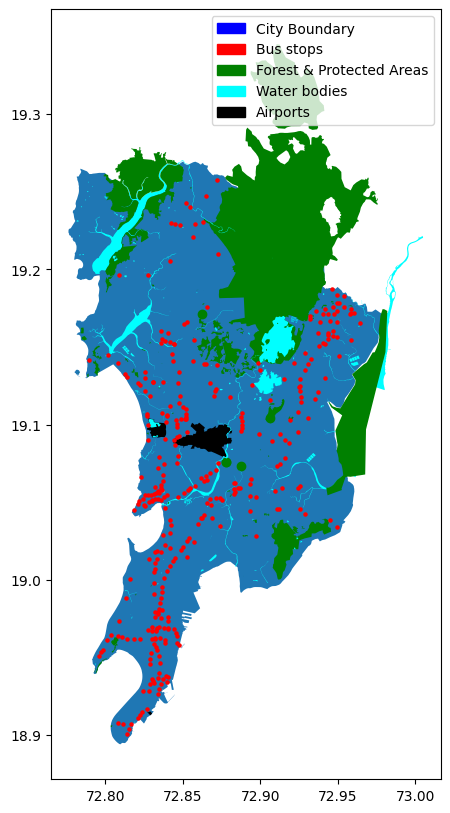

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
mumbai = ox.geocode_to_gdf("Mumbai, India")
airport = ox.geometries.geometries_from_place('Mumbai',tags={'aeroway':'aerodrome'})
national_park = ox.geometries.geometries_from_place('Mumbai',tags={'boundary':'protected_area'})
lakes = ox.geometries.geometries_from_place('Mumbai',tags={'natural':'water'})#,tags={'water':'lake','water':'river'})
forests = ox.geometries.geometries_from_place('Mumbai',tags={'natural':'wood','boundary':'forest','boundary':'national_park'})
fig, ax = plt.subplots(figsize=(10, 10))
mumbai.plot(ax=ax)
airport.plot(ax=ax, color='black')
forests.plot(ax=ax, color='green')
lakes.plot(ax=ax,color='cyan')
national_park.plot(ax=ax, color='green')
locations.plot(ax=ax,color='red',markersize=5)

blue_patch = mpatches.Patch(color='blue', label='City Boundary')
red_patch = mpatches.Patch(color='red', label='Bus stops')
green_patch = mpatches.Patch(color='green', label='Forest & Protected Areas')
cyan_patch = mpatches.Patch(color='cyan', label='Water bodies')
black_patch = mpatches.Patch(color='black', label='Airports')
plt.legend(handles=[blue_patch,red_patch,green_patch,cyan_patch,black_patch])

 If we observe here, much of the north central part is void of any stops. This is due to the area falling under the National Park area of the city. Also in the very centre of the city, due to the presence of airport, connectivity is low but around it there is high volume of stops. In northern part of the city, many stops are unlocated in osm due to mismatch in names or any other reason.

 #### Count Analysis
 We calculated nodes with the highest bus count while creating the graph. Let's take a look at the nodes which have the highest count.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


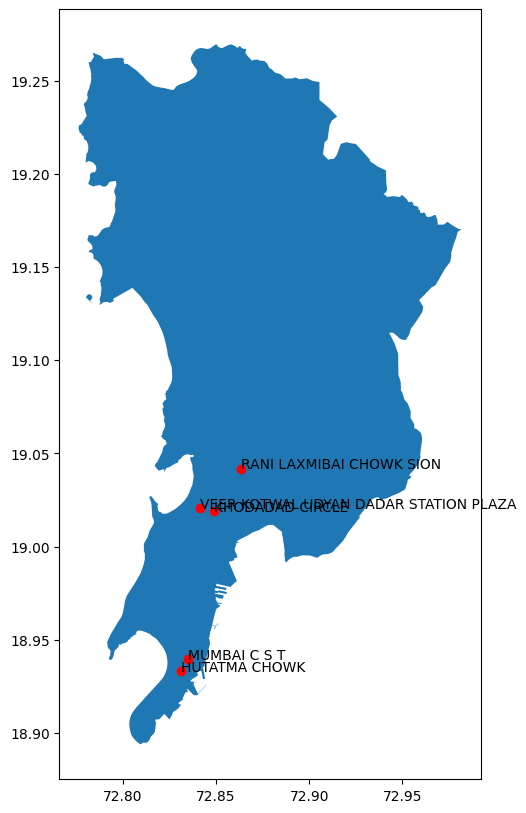

In [13]:
node_freqs = G.nodes(data=True)
top_5_nodes = sorted(node_freqs,key=lambda x: x[1]['count'],reverse=True)[:10]
fig, ax = plt.subplots(figsize=(10, 10))
mumbai = ox.geocode_to_gdf("Mumbai, India")
mumbai.plot(ax=ax)
count = 0
for i in top_5_nodes:
  if i[0] in locations['scraped_stop'].tolist():
    loc = locations[locations['scraped_stop']==i[0]]
    loc.plot(ax=ax, color='red')
    plt.text(loc['geometry'].iloc[0].centroid.coords[0][0],loc['geometry'].iloc[0].centroid.coords[0][1],i[0])
    count += 1
  if count == 5:
    break

We can see that the 4 of the 5 nodes lie in the region called South Mumbai. Besides the 2 at southern part of Mumbai, 3 are in the region where the western and central regions of Mumbai connect. Hence the reason for these places having higher number of bus routes passing through them. For the 2 at the southern tip, many routes start from the region to reach the suburbs, giving them higher frequency.

#### PageRank
PageRank is one of the most talked about and widely used measure. It assigns an importance score to each node. Usually, nodes with the same degree might not be of the same importance. Some links which come from higher importance nodes can be of more significance compared to the links coming from nodes which have lower importance. This is given importance in PageRank. In this context, it can be used to find key stops in the transportation system.

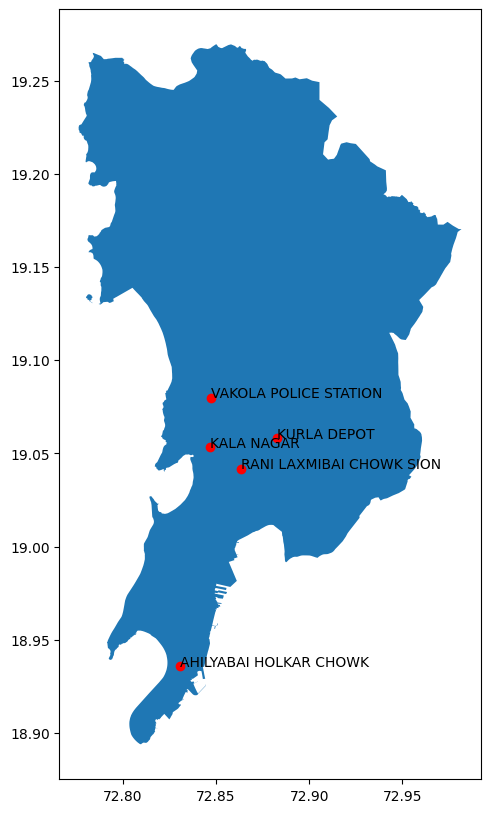

In [15]:
pageranks = nx.pagerank(G)
top_5_nodes = sorted(pageranks.items(),key=lambda x:x[1],reverse=True)[:10]
fig, ax = plt.subplots(figsize=(10, 10))
mumbai.plot(ax=ax)
count = 0
for i in top_5_nodes:
  if i[0] in locations['scraped_stop'].tolist():
    loc = locations[locations['scraped_stop']==i[0]]
    loc.plot(ax=ax, color='red')
    plt.text(loc['geometry'].iloc[0].centroid.coords[0][0],loc['geometry'].iloc[0].centroid.coords[0][1],i[0])
    count += 1
  if count == 5:
    break

With Pagerank scoring, 4 out of the 5 most important nodes are found to be in the central part of Mumbai. These 4 stand out as important because of their high proximity to one of the business hub area of Mumbai called BKC. Ahilyabai Holkar Chowk comes close to Churchgate station which is the station where all western railway trains terminate. This area too hosts many important places pertaining to business, sports and cultural aspects of Mumbai, hence having a higher score on the pagerank analysis.